<a href="https://colab.research.google.com/github/cxbxmxcx/EatNoEat/blob/master/Chapter_9_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network

In 2015, Google DeepMind ([Link](https://deepmind.com/research/dqn/)) published a paper in Nature magazine that combines a deep convolution neural network with reinforcement learning for the first time in order to master a range of Atari 2600 games. They used only the raw pixels and score as the inputs. They were able to use the convolution layer to translate the pixels.  

The very simple description is that they replaced the Q table in a Q-Learner with a neural network. This allowed them to take advantage of neural networks but still use reinforcement learning. 

In [1]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

[50]

**Experience Replay**  
Definition: A mechanism inspired by biology that randomizes over the data removing the correlation in the observation sequence and smoothing over changes in the data distribution.  

To perform an experience replay, the algorithm stores all of the agents experiences {$s_t,a_t,r_t,s_{t+1}$} at each time step in a data set. Normally in a q-learner, we would run the update rule on them. But, with experience replay we just store them.  

Later during the training process these replays will be drawn uniformly from the memory queue and be ran through the update rule. There are 2 ways to handle this and I have coded both in the past. The first is to run them on every loop and the other is to run them after X amount of runs. In this code below, I run them each time.

**Side Track: Vectorization**  
I am going to take some time to talk about vectorization. If you are experienced with python you can skip this part. But, I went from running 100 episodes in mutliple minutes to being able to run 500 in less than 1.  

The idea is that you execute the same task on ALL entries in an array at the same time.  

Old way:

In [2]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
for i in range(100):
    tmp_array[i] += 10
print(tmp_array)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]


Vectorized

In [3]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
tmp_array = np.array(tmp_array) + 10
print(tmp_array)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]


Most of these vectorizations will be calling a method versus just adding 10 but this is a simple solution. You will see a TREMENDOUS speed up avoiding the loops in python

**CartPole Example**  
Again we will use the [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment from OpenAI.  

The actions are 0 to push the cart to the left and 1 to push the cart to the right.  

The continuous state space is an X coordinate for location, the velocity of the cart, the angle of the pole, and the velocity at the tip of the pole. The X coordinate goes from -4.8 to +4.8, velocity is -Inf to +Inf, angle of the pole goes from -24 degrees to +24 degrees, tip velocity is -Inf to +Inf. With all of the possible combinations you can see why we can't create a Q table for each one.  

To "solve" this puzzle you have to have an average reward of > 195 over 100 consecutive episodes. One thing to note, I am hard capping the rewards at 210 so this number can't average above that and it also could potentially drive the average down.

In [0]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [0]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

**Deep Q-Network Class**  
The following class is the deep Q-network that is built using the neural network code from Keras.  
**init**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This creates the class and sets the local parameters.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I use a *deque* for the local memory to hold the experiences and a keras model for the NN.  

**build_model(self)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This builds the NN. I am using sequential model. Each of the layers are *Dense* despite the fact the document talks about using *Convolution*. But, they are only using that because they need to convert pixels and I already have numbers.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I am using an input layer(4), 24 neuron layer, 24 neuron layer, and an output layer(2).  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For calculating the loss I am using mean squared error.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For an optimizer I am using [Adam](https://arxiv.org/abs/1412.6980v8). It is a variant of gradient descent and you can read the technical document at the link. If you want a slightly lighter explaining you can check out [Machine Learning Mastery](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). You could also use SGD (Stochastic Gradient Descent) but Adam gives me better results and seems to be the standard in most examples.  

**action(self,state)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This generates the action.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Explore: I am using the epsilon like previous lessons.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Exploit: I use the NN to grab the 2 possible actions and then grab the argmax to find the better one  

**test_action(self,state)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This generates the action when I am testing. I want to 100% exploit  

**store(self, state, action, reward, nstate, done)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This places the observables in memory  

**experience_replay(self, batch_size)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This is where the training occurs. We grab the sample batches and then use the NN to predict the optimal action.  

In [0]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [0]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

In [8]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 13.0, e: 1
episode: 1/500, score: 10.0, e: 1
episode: 2/500, score: 17.0, e: 0.9275689688183278
episode: 3/500, score: 19.0, e: 0.8475428503023453
episode: 4/500, score: 35.0, e: 0.7147372386831305
episode: 5/500, score: 12.0, e: 0.6763948591909945
episode: 6/500, score: 16.0, e: 0.6274028820538087
episode: 7/500, score: 13.0, e: 0.5907768628656763
episode: 8/500, score: 17.0, e: 0.5452463540625918
episode: 9/500, score: 14.0, e: 0.510849320360386
episode: 10/500, score: 12.0, e: 0.483444593917636
episode: 11/500, score: 32.0, e: 0.41386834584198684
episode: 12/500, score: 17.0, e: 0.3819719776053028
episode: 13/500, score: 13.0, e: 0.3596735257153405
episode: 14/500, score: 10.0, e: 0.3438081748424137
episode: 15/500, score: 10.0, e: 0.32864265128599696
episode: 16/500, score: 10.0, e: 0.3141460853680822
episode: 17/500, score: 13.0, e: 0.29580711868545667
episode: 18/500, score: 12.0, e: 0.2799384215094006
episode: 19/500, score: 11.0, e: 0.2662522686041882
epi

In [9]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/411, score: 210.0, e: 0
episode: 1/411, score: 210.0, e: 0
episode: 2/411, score: 210.0, e: 0
episode: 3/411, score: 210.0, e: 0
episode: 4/411, score: 210.0, e: 0
episode: 5/411, score: 210.0, e: 0
episode: 6/411, score: 210.0, e: 0
episode: 7/411, score: 193.0, e: 0
episode: 8/411, score: 210.0, e: 0
episode: 9/411, score: 210.0, e: 0
episode: 10/411, score: 210.0, e: 0
episode: 11/411, score: 210.0, e: 0
episode: 12/411, score: 210.0, e: 0
episode: 13/411, score: 210.0, e: 0
episode: 14/411, score: 210.0, e: 0
episode: 15/411, score: 210.0, e: 0
episode: 16/411, score: 210.0, e: 0
episode: 17/411, score: 210.0, e: 0
episode: 18/411, score: 210.0, e: 0
episode: 19/411, score: 210.0, e: 0
episode: 20/411, score: 210.0, e: 0
episode: 21/411, score: 210.0, e: 0
episode: 22/411, score: 210.0, e: 0
episode: 23/411, score: 210.0, e: 0
episode: 24/411, score: 210.0, e: 0
episode: 25/411, score: 210.0, e: 0
episode: 26/411, score: 210.0, e: 0
episode: 27/411, score: 210.0, e: 0
ep

In [10]:
print(nS, nA)

4 2


**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Black: This is the 100 episode rolling average  
Red: This is the "solved" line at 195  
Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: This is where the tests started.

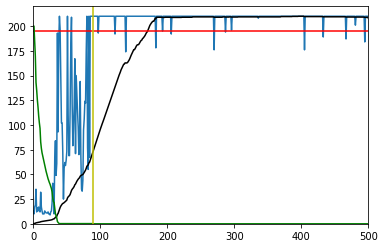

In [11]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()

**Changes**  
*hyper parameters*: You can alter alpha, gamma, batch size, and episode length to see what differences the algorithm returns.  
*Training End*: You can also change the line where I only check the last 5 runs before switching to testing mode (if len(rewards) > 5 and np.average(rewards[-5:]) > 195:) as that doesn't prove it was solved. The reason I did this was because I wanted to limit the amount of runs I made.  

**Conclusion**  
This is a Deep Q-Network implementation. There are some changes you can make here and there but it follows the paper. Hopefully, you were able to understand the code as well as make your own version to compare with this one.

**Reference**  
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Petersen, S. (2015). *Human-level control through deep reinforcement learning*. Nature, 518(7540), 529